In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
plt.style.use('ggplot')

In [2]:
dataset_path = "../../data/ml-100k/u.data"

In [3]:
def load_movielens(dataset_path, names=['user_id', 'item_id', 'rating', 'timestamp']):
    data = pd.read_csv(dataset_path, sep="\t", names=names)
    return data

In [4]:
data = load_movielens(dataset_path)
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
n_users = data.user_id.unique().shape[0]
n_items = data.item_id.unique().shape[0]

ratings = coo_matrix( (data.rating, (data.user_id - 1, data.item_id - 1)), (n_users, n_items) )

In [6]:
print(str(n_users) + ' users')
print(str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

943 users
1682 items
Sparsity: 6.30%


In [7]:
def train_test_split(ratings, test_size=0.3):
    row_non_zero, col_non_zero = ratings.nonzero()
    
    n_all = row_non_zero.shape[0]
    n_test_samples = int(test_size*n_all)
    
    idx = np.arange(n_all, dtype=int)
    idx_test = np.random.choice(idx, n_test_samples, replace=False)
    idx_train = np.setdiff1d(idx, idx_test)
    
    train = coo_matrix( (ratings.data[idx_train], (row_non_zero[idx_train], col_non_zero[idx_train])), shape=ratings.shape )
    test = coo_matrix( (ratings.data[idx_test], (row_non_zero[idx_test], col_non_zero[idx_test])), shape=ratings.shape )
    return train, test

In [8]:
train, test = train_test_split(ratings)

train = train.todense()
test = test.todense()

In [9]:
def mean_squared_error(pred, actual):
    return np.mean( (pred - actual)**2 )

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = np.asarray(pred[actual.nonzero()]).flatten()
    actual = np.asarray(actual[actual.nonzero()]).flatten()
    return mean_squared_error(pred, actual)

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);


class ExplicitMF:
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda
            latent_vectors = np.linalg.solve((YTY + lambdaI), ratings.dot(fixed_vecs).T).T
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            latent_vectors = np.linalg.solve((XTX + lambdaI), ratings.T.dot(fixed_vecs).T).T
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict the ratings for the whole matrix """
        return self.user_vecs.dot(self.item_vecs.T)

    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

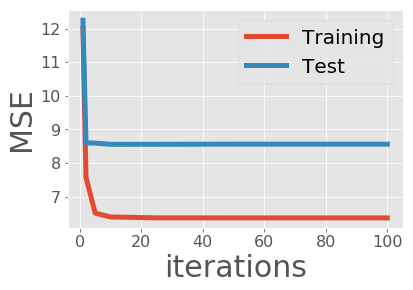

In [35]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=40, item_reg=30)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)
plot_learning_curve(iter_array, MF_ALS)